In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import zipfile

import numpy as np
from six.moves import urllib
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Step 1: 데이터 다운로드
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename


def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        names = f.namelist()                # ['text8']
        contents = f.read(names[0])         # 크기 : 100,000,000바이트
        text = tf.compat.as_str(contents)   # 크기 : 100,000,000
        return text.split()                 # 갯수 : 17005207


filename = maybe_download('text8.zip', 31344016)
vocabulary = read_data(filename)
print('Data size', len(vocabulary))         # 17005207

Found and verified text8.zip
Data size 17005207


In [3]:
# Step 2: 사전을 구축하고 거의 등장하지 않는 단어를 UNK 토큰으로 대체.
vocabulary_size = 50000


def build_dataset(words, n_words):
    unique = collections.Counter(words)             # 중복 단어 제거
    orders = unique.most_common(n_words - 1)        # 단어에 대한 빈도 계산. 갯수를 지정하지 않으면 전체 계산.
    count = [['UNK', -1]]
    count.extend(orders)

    # dictionary : (UNK, 0) (the, 1) (of, 2) (and, 3) (one, 4) (in, 5) (a, 6) (to, 7)
    dictionary = {word: i for i, (word, _) in enumerate(count)}

    data = []
    for word in words:
        if word in dictionary:          # word가 dictionary에 존재한다면
            index = dictionary[word]
        else:
            index = 0                   # UNK는 0번째에 위치
            count[0][1] += 1            # 갯수 : 418391
        data.append(index)

    return data, count, list(dictionary.keys())


data, count, ordered_words = build_dataset(vocabulary, vocabulary_size)
del vocabulary, count               # 사용하지 않는 변수 삭제

In [4]:
# Step 3: skip-gram 모델에 사용할 학습 데이터를 생성할 함수 작성

def generate_batch(data, batch_size, num_skips, skip_window, data_index):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    span = 2 * skip_window + 1                      # context = skip_window + target + skip_window
    assert span > num_skips

    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)   # 다음 단어 인덱스로 이동. len(data) = 17005207

    for i in range(batch_size // num_skips):

        targets = list(range(span))     # 1. 0부터 span-1까지의 정수로 채운 다음
        targets.pop(skip_window)        # 2. skip_window번째 삭제
        np.random.shuffle(targets)      # 3. 난수를 사용해서 섞는다.

        start = i * num_skips
        batch[start:start+num_skips] = buffer[skip_window]

        for j in range(num_skips):
            labels[start+j, 0] = buffer[targets[j]]

        # 새로운 요소가 들어가면서 가장 먼저 들어간 데이터 삭제
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels, data_index

In [5]:
# Step 4: skip-gram 모델 구축
np.random.seed(1)
tf.set_random_seed(1)

batch_size = 128        # 일반적으로 16 <= batch_size <= 512
embedding_size = 128    # embedding vector 크기
skip_window = 1         # target 양쪽의 단어 갯수
num_skips = 2           # 컨텍스트로부터 생성할 레이블 갯수

valid_size = 16     # 유사성을 평가할 단어 집합 크기
valid_window = 100  # 앞쪽에 있는 분포들만 뽑기 위한 샘플
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # negative 샘플링 갯수

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

truncated = tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size))
nce_weights = tf.Variable(truncated)
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# embeddings 벡터. embed는 바로 아래 있는 tf.nn.nce_loss 함수에서 단 1회 사용
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# 배치 데이터에 대해 NCE loss 평균 계산
nce_loss = tf.nn.nce_loss(weights=nce_weights,
                          biases=nce_biases,
                          labels=train_labels,
                          inputs=embed,
                          num_sampled=num_sampled,
                          num_classes=vocabulary_size)
loss = tf.reduce_mean(nce_loss)

# SGD optimizer
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

# 유사도를 계산하기 위한 모델. 학습 모델은 optimizer까지 구축한 걸로 종료.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
# Step 5: skip-gram 모델 학습
num_steps = 100001

with tf.Session() as session:
    session.run(tf.global_variables_initializer())

    average_loss, data_index = 0, 0
    for step in range(num_steps):
        batch_inputs, batch_labels, data_index = generate_batch(data, batch_size, num_skips, skip_window, data_index)

        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        # 마지막 2000번에 대한 평균 loss 표시
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print('Average loss at step {} : {}'.format(step, average_loss))
            average_loss = 0

        if step % 10000 == 0:
            sim = similarity.eval()         # (16, 50000)

            for i in range(valid_size):
                valid_word = ordered_words[valid_examples[i]]

                top_k = 8
                nearest = sim[i].argsort()[-top_k - 1:-1][::-1]
                log_str = ', '.join([ordered_words[k] for k in nearest])
                print('Nearest to {}: {}'.format(valid_word, log_str))

    final_embeddings = normalized_embeddings.eval()


Average loss at step 0 : 289.803466796875
Nearest to over: eur, dwarves, lilian, chapman, krieger, distinguishes, firestorm, ccr
Nearest to war: pistol, bight, wingers, quesada, skiers, latvian, bcp, movements
Nearest to this: jake, sited, tr, terminating, smoke, conformations, liquefied, necessitates
Nearest to years: mallard, rd, blob, hips, nol, annals, dodds, ruins
Nearest to often: bungalow, debrecen, polyethylene, bohr, steve, reflected, treasury, hindus
Nearest to three: text, ctv, assassinations, socializing, elects, meditation, protege, battlecruiser
Nearest to he: dandridge, withdraw, cosets, weakness, saddam, greenman, meyers, cryogenic
Nearest to states: tcl, vehement, sucrose, sanctioned, punjab, mighty, battlefront, amides
Nearest to may: wig, runequest, cameroun, report, dlp, zx, exacting, minimizing
Nearest to time: ditko, pops, urinating, arguing, firsthand, abuse, secrecy, marcius
Nearest to system: andrzej, intercalary, genres, pentateuch, feud, mitre, symbolise, aar

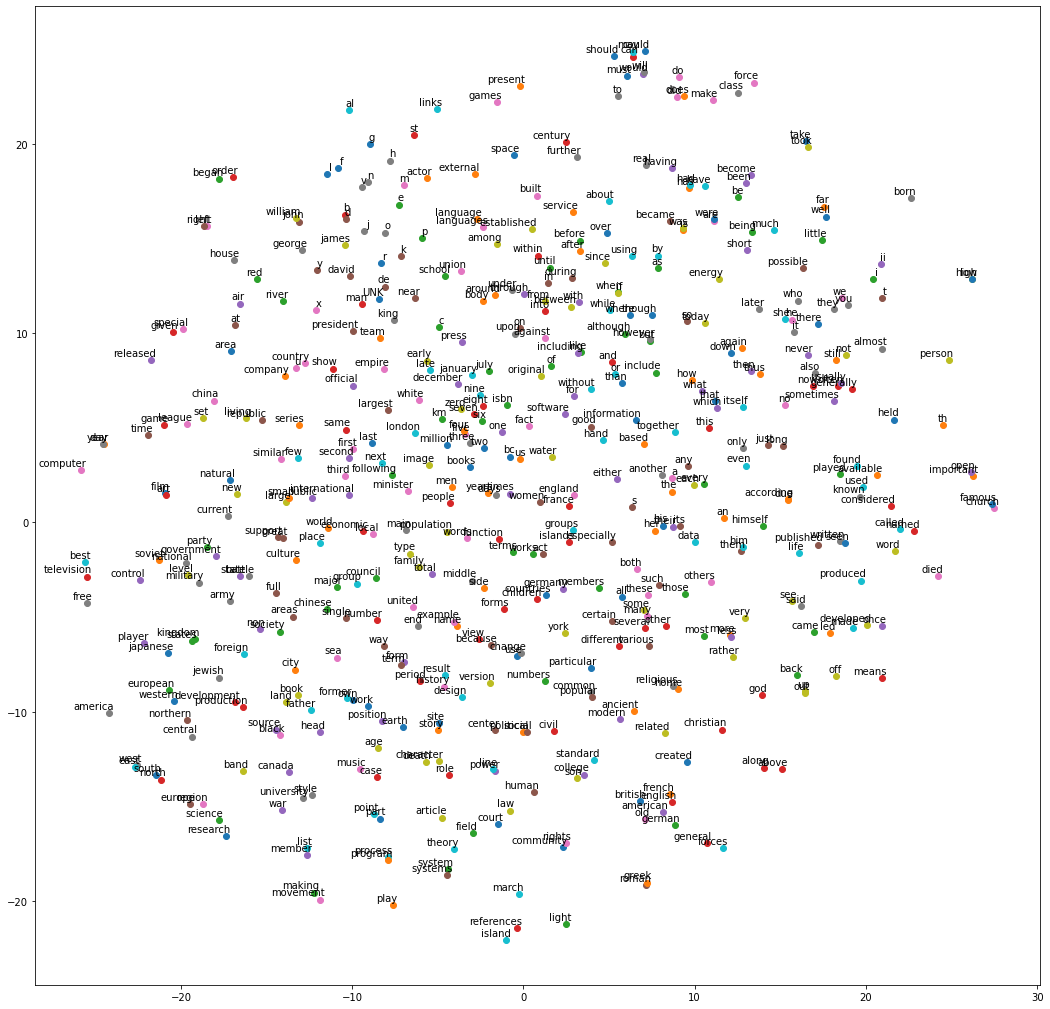

In [7]:
# Step 6: embeddings 시각화

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'

    plt.figure(figsize=(18, 18))        # in inches

    for (x, y), label in zip(low_dim_embs, labels):
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only])     # (500, 2)
    labels = ordered_words[:plot_only]                                  # 재구성한 코드

    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')